# import and functions 

In [1]:
import os
import pandas as pd
import numpy as np  
from datetime import datetime
import matplotlib.pyplot as plt
import cv2
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import shutil
from datetime import datetime


def process_camera_data(Camera_ts_raw):

    Camera_ts = convert_uncycle_Timestamps(Camera_ts_raw)

    #check for dropped frames:
    check_timestamps(Camera_ts, Frame_rate = 60)
    # Find triggers:
    Camera_trig_states = find_trigger_states(Camera_ts_raw)
    #check if triggers are working:
    result = np.max(Camera_trig_states) == np.min(Camera_trig_states)
    
    # #pull out video name
    # video_name = [TimeStampPath.split("\\")[-1].split(".")[0] + '-camera-timestamp-data']

    if not result:

        # make camera dataframe:
        Camera_dataframe = pd.DataFrame(
            {'Time Stamps': Camera_ts,
            'Trigger State': Camera_trig_states,
            # 'DataPath': ([TimeStampPath] * len(Camera_ts))
            })
        
    return Camera_dataframe

def converttime(time):
    #offset = time & 0xFFF
    cycle1 = (time >> 12) & 0x1FFF
    cycle2 = (time >> 25) & 0x7F
    seconds = cycle2 + cycle1 / 8000.
    return seconds

def uncycle(time):
    cycles = np.insert(np.diff(time) < 0, 0, False)
    cycleindex = np.cumsum(cycles)
    return time + cycleindex * 128

def convert_uncycle_Timestamps(Camera_ts):
    ##################   Convert the timestamps into seconds and uncycle them:
    t_stamps = {}  
    stamps_s = []
    for indx, row in Camera_ts.iterrows():
        if row.trigger > 0: 
            timestamp_new = converttime(int(row.timestamps))
            stamps_s.append(timestamp_new)
        # else:    
        #     raise ValueError('Timestamps are broken')
    t_stamps = uncycle(stamps_s)
    t_stamps = t_stamps - t_stamps[0] # make first timestamp 0 and the others relative to this 
    return(t_stamps)

def check_timestamps(t_stamps, Frame_rate):
    # plot 1/(diff between time stamps). This tells you roughly the frequency and if you've droppped frames.
    Frame_gaps = 1/np.diff(t_stamps)
    Frames_dropped = 0
    for gaps in Frame_gaps:
        if gaps < (Frame_rate-5) or gaps > (Frame_rate+5):
            Frames_dropped = Frames_dropped + 1
    print('Frames dropped = ' + str(Frames_dropped))

    plt.suptitle('Frame rate = ' + str(Frame_rate) + 'fps', color = 'red')
    frame_gaps = plt.hist(Frame_gaps, bins=100)
    plt.xlabel('Frequency')
    plt.ylabel('Number of frames')
    
def find_trigger_states(Camera_ts_raw):
    triggers = Camera_timestamps.trigger.values[np.where(Camera_timestamps.loc[:,'trigger']>0)]
    down_state = list(triggers)[0]
    down_state_times = np.where(triggers == down_state)
    Triggers_temp = np.ones(len(triggers))
    for index in down_state_times:
        Triggers_temp[index] = 0
    trigger_state = Triggers_temp
    return trigger_state

def load_video(path):
    return cv2.VideoCapture(path)

def get_total_frames(cap):
    return int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

def calculate_interval(total_frames, num_frames):
    return total_frames // num_frames

def process_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    gray_frame = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2GRAY)
    blurred_frame = cv2.GaussianBlur(gray_frame, (15, 15), 0)
    circles = cv2.HoughCircles(blurred_frame, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=50, param2=30, minRadius=25, maxRadius=40)
    return frame_rgb, circles

def draw_circles(frame_rgb, circles):
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(frame_rgb, (x, y), r, (0, 255, 0), 4)
            cv2.rectangle(frame_rgb, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
        return len(circles)
    return 0

def analyze_video_type(cam_path, start_time, end_time, num_frames=20):
    cap = load_video(cam_path)
    total_frames = get_total_frames(cap)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)
    interval = (end_frame - start_frame) // num_frames
    
    fig, axes = plt.subplots(2, int(np.ceil(num_frames / 2)), figsize=(15, 6))
    circles_count = []

    for i in range(num_frames):
        frame_number = start_frame + i * interval
        if frame_number > end_frame:
            break
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        if ret:
            frame_rgb, circles = process_frame(frame)
            count = draw_circles(frame_rgb, circles)
            circles_count.append(count)
            
            ax = axes[i // int(np.ceil(num_frames / 2)), i % int(np.ceil(num_frames / 2))]
            ax.imshow(frame_rgb)
            ax.set_title(f'Frame {frame_number}')
            ax.axis('off')
        else:
            print(f"Error: Could not read frame at position {frame_number}.")
            circles_count.append(0)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(num_frames), circles_count, marker='o')
    plt.xlabel('Frame Index')
    plt.ylabel('Number of Circles Detected')
    plt.title('Number of Circles Detected in Each Frame')
    plt.show()
    return circles_count

def convert_seconds(total_seconds):
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return hours, minutes, seconds


def check_time_dropped(times,Frame_rate = 60):
    
    # Calculate the expected time difference between frames
    expected_diff = 1 / Frame_rate

    # Calculate the actual time differences between frames
    actual_diffs = np.diff(times)

    # Identify where frames have been dropped
    dropped_frames = np.where((actual_diffs < expected_diff - 0.001) | (actual_diffs > expected_diff + 0.001))[0]

    # Calculate the total time dropped
    total_time_dropped = np.sum(actual_diffs[dropped_frames] - expected_diff)

    print(f"Total frames dropped: {len(dropped_frames)}")
    print(f"Total time dropped is approximatley: {total_time_dropped} seconds")

    # Example usage
    total_seconds = total_time_dropped
    hours, minutes, seconds = convert_seconds(total_seconds)
    print(f"{total_seconds} seconds is equal to {hours} hours, {minutes} minutes, and {seconds} seconds.")
    


def convert_date_format(date_str):
    date_obj = datetime.strptime(date_str, '%Y%m%d')
    formatted_date = date_obj.strftime('%d-%m-%Y')
    return formatted_date

    

In [3]:
base_path = r"Z:\projects\sequence_squad\revision_data\lars_recordings\video\\"
save_path_base = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"

files_to_process = []
full_files_to_process = []
for mouse_file in os.listdir(base_path):
    mouse_base = os.path.join(base_path, mouse_file)
    for recording in os.listdir(mouse_base):
        full_file = os.path.join(mouse_base, recording)
        for file in os.listdir(full_file):
            if '.csv' in file:
                full_files_to_process += [full_file]
                files_to_process+=[file]
                
                mouse_file = full_file.split('\\')[-2]
                mouse_file = mouse_file.lower()
                if 'ap5' in mouse_file:
                    mouse_file = mouse_file.split('_')[0] + mouse_file.split('_')[-1]
                
                ## handle weird differences in data naming
                if not mouse_file in file:
                    if 'camera' in file:
                        date = file.split('_')[1][0:-3]
                    else:
                        date = file.split('_')[1][1:11]
                else:
                    date = convert_date_format(file.split('__')[1])
                    date_obj = datetime.strptime(date, '%d-%m-%Y')
                    date = date_obj.strftime('%Y-%m-%d')
                    
                for forbidden_file in os.listdir(r"Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\other_sessions\\"):
                    if mouse_file in forbidden_file and date in forbidden_file:
                        print(forbidden_file)
                        print(full_file)
                        #remove this item 
                        full_files_to_process.pop()
                        files_to_process.pop()
                        break
                    
                    
    
   


ap5r_2024-11-11_14-55-34
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\AP5_2_R\AP5_2_R__20241111
ap5r_2024-11-11_14-55-34
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\AP5_2_R\AP5_2_R__20241111
ap5r_2024-11-12_13-10-27
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\AP5_2_R\AP5_2_R__20241112
ap5r_2024-11-12_13-10-27
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\AP5_2_R\AP5_2_R__20241112
ap5lr_2024-11-13_09-43-32
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\AP5_3_LR\AP5_3_LR__20241113
ap5lr_2024-11-13_09-43-32
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\AP5_3_LR\AP5_3_LR__20241113
ap5lr_2024-11-14_10-06-19
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\AP5_3_LR\AP5_3_LR__20241114
ap5lr_2024-11-14_10-06-19
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\AP5_3_LR\AP5_3_LR__20241114
ap5lr_2024-11-22_09-32-10
Z:\projects\sequence_squad\revision_data\l

In [4]:
for i in range(len(files_to_process)):
    file = files_to_process[i]
    full_file = full_files_to_process[i]
    
    # find save path
    full_cam_save_path = 'Error'
    current_amimal = full_file.split('\\')[-1].split('__')[0]
    for f_path in os.listdir(save_path_base):
        if current_amimal in f_path:
            print('found')
            full_cam_save_path = os.path.join(save_path_base, f_path)
        elif current_amimal.split('_')[0].lower() + current_amimal.split('_')[-1]+'_' in f_path:
            full_cam_save_path = os.path.join(save_path_base, f_path)
        elif current_amimal.split('_')[0].lower() + current_amimal.split('_')[-1].lower()+'_' in f_path:
            full_cam_save_path = os.path.join(save_path_base, f_path)
    formatted_date = convert_date_format(full_file.split('\\')[-1].split('__')[-1])

    full_cam_save_path_task = None
    full_cam_save_path_pre = None
    full_cam_save_path_post = None
    for fi_path in os.listdir(full_cam_save_path):
        if formatted_date in fi_path:
            full_cam_save_path_task = os.path.join(full_cam_save_path, fi_path,'video','videos','2_task')
            full_cam_save_path_pre = os.path.join(full_cam_save_path, fi_path,'video','videos','1_presleep')
            full_cam_save_path_post = os.path.join(full_cam_save_path, fi_path,'video','videos','3_postsleep')
            
    #if not existing already, make a new dir
    for path in [full_cam_save_path_task, full_cam_save_path_pre, full_cam_save_path_post]:
        if not os.path.isdir(path):
            os.makedirs(path)
            
    print(os.path.join(full_file,file))
    print(full_cam_save_path)
    print('----------------')
    break

Z:\projects\sequence_squad\revision_data\lars_recordings\video\\AP5_1_L\AP5_1_L__20241118\camera1_2024-11-18T14_00_31.csv
Z:\projects\sequence_squad\revision_data\organised_data\animals\\ap5L_implant1
----------------


# processing loop

**************** PROCESSING ****************
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\AP5_1_L\AP5_1_L__20241118\camera1_2024-11-18T14_00_31.csv
Frames dropped = 10
Total frames dropped: 10
Total time dropped is approximatley: 9.994833333331218 seconds
9.994833333331218 seconds is equal to 0.0 hours, 0.0 minutes, and 9.994833333331218 seconds.
[(0, 174), (306, 518)]


KeyboardInterrupt: 

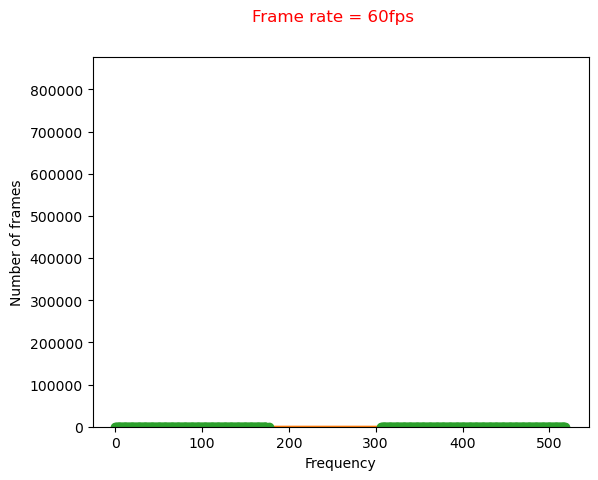

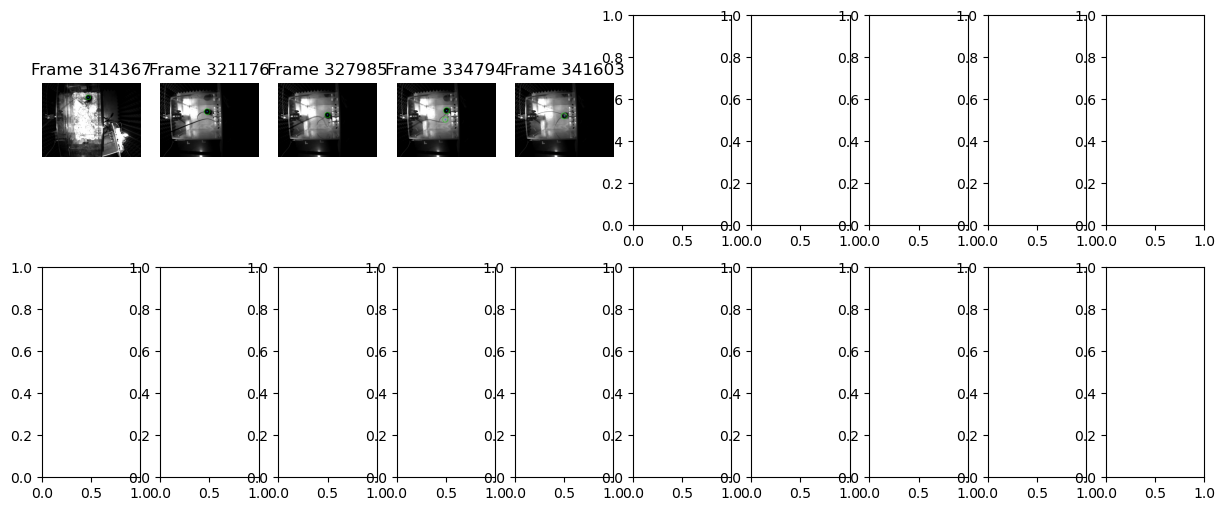

In [5]:
for i in range(len(files_to_process)):
    file = files_to_process[i]
    full_file = full_files_to_process[i]
    
    # find save path
    full_cam_save_path = 'Error'
    current_amimal = full_file.split('\\')[-1].split('__')[0]
    for f_path in os.listdir(save_path_base):
        if current_amimal in f_path:
            print('found')
            full_cam_save_path = os.path.join(save_path_base, f_path)
        elif current_amimal.split('_')[0].lower() + current_amimal.split('_')[-1] in f_path:
            full_cam_save_path = os.path.join(save_path_base, f_path)
        elif current_amimal.split('_')[0].lower() + current_amimal.split('_')[-1].lower() in f_path:
            full_cam_save_path = os.path.join(save_path_base, f_path)
    formatted_date = convert_date_format(full_file.split('\\')[-1].split('__')[-1])

    full_cam_save_path_task = None
    full_cam_save_path_pre = None
    full_cam_save_path_post = None
    for fi_path in os.listdir(full_cam_save_path):
        if formatted_date in fi_path:
            full_cam_save_path_task = os.path.join(full_cam_save_path, fi_path,'video','videos','2_task')
            full_cam_save_path_pre = os.path.join(full_cam_save_path, fi_path,'video','videos','1_presleep')
            full_cam_save_path_post = os.path.join(full_cam_save_path, fi_path,'video','videos','3_postsleep')
            
    #if not existing already, make a new dir
    for path in [full_cam_save_path_task, full_cam_save_path_pre, full_cam_save_path_post]:
        if not os.path.isdir(path):
            os.makedirs(path)
    
    ### PROCESS 
    
    print("**************** PROCESSING ****************")
    print(os.path.join(full_file, file))

    Camera_timestamps = pd.read_csv(os.path.join(full_file, file))
    
    if len(Camera_timestamps.columns) > 1:
        Camera_timestamps.columns = ['trigger', 'timestamps', 'blank']
        Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
    else:
        Camera_timestamps[['trigger', 'timestamps', 'blank']] = Camera_timestamps.iloc[:, 0].str.split(expand=True)
        Camera_timestamps.drop(Camera_timestamps.columns[0], axis=1, inplace=True)
        Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
        
    #check if timestmaps are reversed
    if int(Camera_timestamps.timestamps.astype(float)[1] - Camera_timestamps.timestamps.astype(float)[0]) == 1:
        Camera_timestamps = Camera_timestamps.rename(columns={'timestamps': 'blank', 'blank': 'timestamps'})
        
        # Convert timestamps to datetime
        Camera_timestamps['datetime'] = pd.to_datetime(Camera_timestamps['timestamps'], unit='ns')
    
        Camera_dataframe = pd.DataFrame({})
        Camera_dataframe['Trigger State'] = find_trigger_states(Camera_timestamps)
        Camera_dataframe['Time Stamps'] = (Camera_timestamps.datetime - Camera_timestamps.datetime[0]).dt.total_seconds()
        check_time_dropped(Camera_dataframe['Time Stamps'].values, Frame_rate = 60)

    else:
        Camera_dataframe = process_camera_data(Camera_timestamps)
        check_time_dropped(Camera_dataframe['Time Stamps'].values, Frame_rate = 60)
        
    ## split into 3 sperates epochs based on triggers
    # find trigger onset times
    trigger_changes = np.where(np.diff(Camera_dataframe['Trigger State'].values) == 1)[0]
    trigger_onset_times = Camera_dataframe['Time Stamps'].values[trigger_changes]

    np.diff(trigger_onset_times)
    sleep_trigger_inds = np.where((np.diff(trigger_onset_times) > 28.5) & (np.diff(trigger_onset_times) < 31.5))

    plt.plot(np.diff(trigger_onset_times))
    plt.plot(np.array(sleep_trigger_inds)[0],np.diff(trigger_onset_times)[sleep_trigger_inds],'o')

    consecutive_chunks = []
    start = None
    for i in range(len(sleep_trigger_inds[0]) - 1):
        if sleep_trigger_inds[0][i + 1] - sleep_trigger_inds[0][i] == 1:
            if start is None:
                start = sleep_trigger_inds[0][i]
        else:
            if start is not None:
                end = sleep_trigger_inds[0][i]
                consecutive_chunks.append((start, end))
                start = None
    if start is not None:
        consecutive_chunks.append((start, sleep_trigger_inds[0][-1]))

    # Remove any chunks that aren't at least 100 long
    consecutive_chunks = [(start, end) for start, end in consecutive_chunks if end - start >= 100]

    print(consecutive_chunks)


    ### determine video type:
    cam_path = None
    for cam_file in os.listdir(full_file):
        if '.avi' in cam_file:
            try:
                if file.split('.csv')[0].split('timestamp')[1] in cam_file:
                    cam_path = os.path.join(full_file,cam_file)
            except:
                if file.split('.csv')[0].split('_')[0] in cam_file:
                    cam_path = os.path.join(full_file,cam_file)
                
    # analyze the video based on cicles detected in frames 
    start = trigger_onset_times[consecutive_chunks[0][-1]]
    end = trigger_onset_times[consecutive_chunks[-1][0]]
    circles_count = analyze_video_type(cam_path,start,end)


    consecutive_threshold = 4
    count_threshold = 5
    consecutive_count = 0
    BACK_CAM = False

    for count in circles_count:
        if count > count_threshold:
            consecutive_count += 1
            if consecutive_count >= consecutive_threshold:
                BACK_CAM = True
                break
        else:
            consecutive_count = 0

    print(BACK_CAM)

    trigger_onset_inds = Camera_dataframe.index.values[trigger_changes]

    task_camera_dataframe = Camera_dataframe[trigger_onset_inds[consecutive_chunks[0][-1]]:trigger_onset_inds[consecutive_chunks[-1][0]]].reset_index(drop=True)
    task_camera_dataframe.rename(columns={'Time Stamps': 'origional_video_ts'}, inplace=True)
    task_camera_dataframe['Time Stamps'] = task_camera_dataframe['origional_video_ts'] - task_camera_dataframe['origional_video_ts'][0]

    presleep_camera_dataframe = Camera_dataframe[0:trigger_onset_inds[consecutive_chunks[0][-1]]].reset_index(drop=True)
    presleep_camera_dataframe.rename(columns={'Time Stamps': 'origional_video_ts'}, inplace=True)
    presleep_camera_dataframe['Time Stamps'] = presleep_camera_dataframe['origional_video_ts'] - presleep_camera_dataframe['origional_video_ts'][0]   

    postsleep_camera_dataframe = Camera_dataframe[trigger_onset_inds[consecutive_chunks[-1][0]]::].reset_index(drop=True)
    postsleep_camera_dataframe.rename(columns={'Time Stamps': 'origional_video_ts'}, inplace=True)
    postsleep_camera_dataframe['Time Stamps'] = postsleep_camera_dataframe['origional_video_ts'] - postsleep_camera_dataframe['origional_video_ts'][0]

    ## save out the split csv files for each epoch
    if BACK_CAM == True:
        plt.plot(np.diff(trigger_onset_times))  
        s = consecutive_chunks[0][-1]
        e = consecutive_chunks[-1][0]
        plt.fill_between(range(s, e), max(np.diff(trigger_onset_times)), np.diff(trigger_onset_times)[s:e], color='red', alpha=0.4)
    else:
        s = 0
        e = consecutive_chunks[0][-1]
        plt.fill_between(range(s, e), max(np.diff(trigger_onset_times)), np.diff(trigger_onset_times)[s:e], color='green', alpha=0.4)

        s = consecutive_chunks[-1][0]
        e = consecutive_chunks[-1][-1]
        plt.fill_between(range(s, e), max(np.diff(trigger_onset_times)), np.diff(trigger_onset_times)[s:e], color='yellow', alpha=0.4)

    # create dunp file for processing the videos with DLC 
    DLC_dump_path_above = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\DLC_video_dump\ABOVE\\"
    if not os.path.exists(DLC_dump_path_above):
        os.makedirs(DLC_dump_path_above)
    DLC_dump_path_back = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\DLC_video_dump\BACK\\"
    if not os.path.exists(DLC_dump_path_back):
        os.makedirs(DLC_dump_path_back)
        
        
    #### save out video clips and make sure they go to the right place:
    if BACK_CAM == True:
        # save out task
        start = trigger_onset_times[consecutive_chunks[0][-1]]
        end = trigger_onset_times[consecutive_chunks[-1][0]]
        print(start,end)
        ffmpeg_extract_subclip(cam_path, start, end, full_cam_save_path_task + "\BACK_task_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.avi')
        # Copy the saved video to another location
        shutil.copy(full_cam_save_path_task + "\BACK_task_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.avi', DLC_dump_path_back) 
        # save out csv
        task_camera_dataframe.to_csv(full_cam_save_path_task + "\BACK_task_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.csv')
        
    else:
        ## save out sleep1
        start = 0 
        end = trigger_onset_times[consecutive_chunks[0][-1]]
        print(start,end)
        ffmpeg_extract_subclip(cam_path, start, end, full_cam_save_path_pre + "\ABOVE_presleep_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.avi')
        # Copy the saved video to another location
        shutil.copy(full_cam_save_path_task + "\ABOVE_presleep_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.avi', DLC_dump_path_above)
        # save out csv
        presleep_camera_dataframe.to_csv(full_cam_save_path_task + "\ABOVE_presleep_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.csv')

        
        # save out postsleep
        start = trigger_onset_times[consecutive_chunks[-1][0]]
        end = trigger_onset_times[consecutive_chunks[-1][-1]]
        print(start,end)
        ffmpeg_extract_subclip(cam_path, start, end, full_cam_save_path_post + "\ABOVE_postleep_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.avi')
        # Copy the saved video to another location
        shutil.copy(full_cam_save_path_task + "\ABOVE_postleep_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.avi', DLC_dump_path_above)
        # save out csv
        postsleep_camera_dataframe.to_csv(full_cam_save_path_task + "\ABOVE_postleep_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.csv')
        
    print('done')
        


# testing area: 

Frames dropped = 64
Total frames dropped: 64
Total time dropped is approximatley: 60.920958333332415 seconds
60.920958333332415 seconds is equal to 0.0 hours, 1.0 minutes, and 0.9209583333324147 seconds.


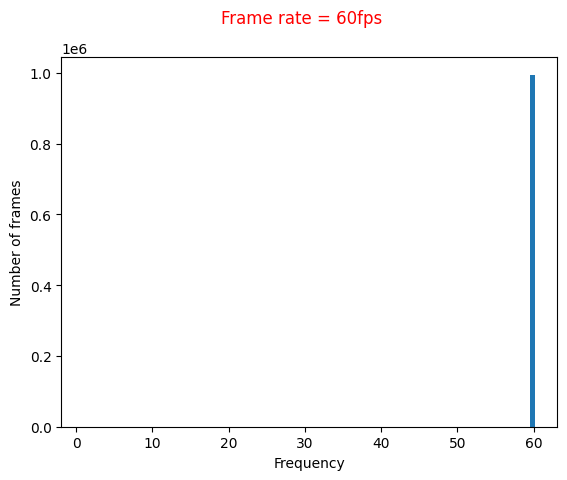

In [ ]:
save_path_base = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
# full_file = r"D:\video_testing\seq006__20241114\\"
full_file = r"D:\video_testing\AP5_1_L__20241119\\"

# file = "seq006__20241114__timestamp_02024-11-14T09_26_38.csv"
# file = "seq006__20241114__timestamp_22024-11-14T09_26_38.csv"

file = "camera2_2024-11-19T14_18_45.csv"




Camera_timestamps = pd.read_csv(os.path.join(full_file, file))

# Camera_timestamps = pd.read_csv(os.path.join(r"D:\video_testing\AP5_1_L__20241119\camera1_2024-11-19T14_18_45.csv"))

if len(Camera_timestamps.columns) > 1:
    Camera_timestamps.columns = ['trigger', 'timestamps', 'blank']
    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
else:
    Camera_timestamps[['trigger', 'timestamps', 'blank']] = Camera_timestamps.iloc[:, 0].str.split(expand=True)
    Camera_timestamps.drop(Camera_timestamps.columns[0], axis=1, inplace=True)
    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
    
#check if timestmaps are reversed
if int(Camera_timestamps.timestamps.astype(float)[1] - Camera_timestamps.timestamps.astype(float)[0]) == 1:
    Camera_timestamps = Camera_timestamps.rename(columns={'timestamps': 'blank', 'blank': 'timestamps'})
    
    # Convert timestamps to datetime
    Camera_timestamps['datetime'] = pd.to_datetime(Camera_timestamps['timestamps'], unit='ns')

    Camera_dataframe = pd.DataFrame({})
    Camera_dataframe['Trigger State'] = find_trigger_states(Camera_timestamps)
    Camera_dataframe['Time Stamps'] = (Camera_timestamps.datetime - Camera_timestamps.datetime[0]).dt.total_seconds()
    check_time_dropped(Camera_dataframe['Time Stamps'].values, Frame_rate = 60)

else:
    Camera_dataframe = process_camera_data(Camera_timestamps)
    check_time_dropped(Camera_dataframe['Time Stamps'].values, Frame_rate = 60)

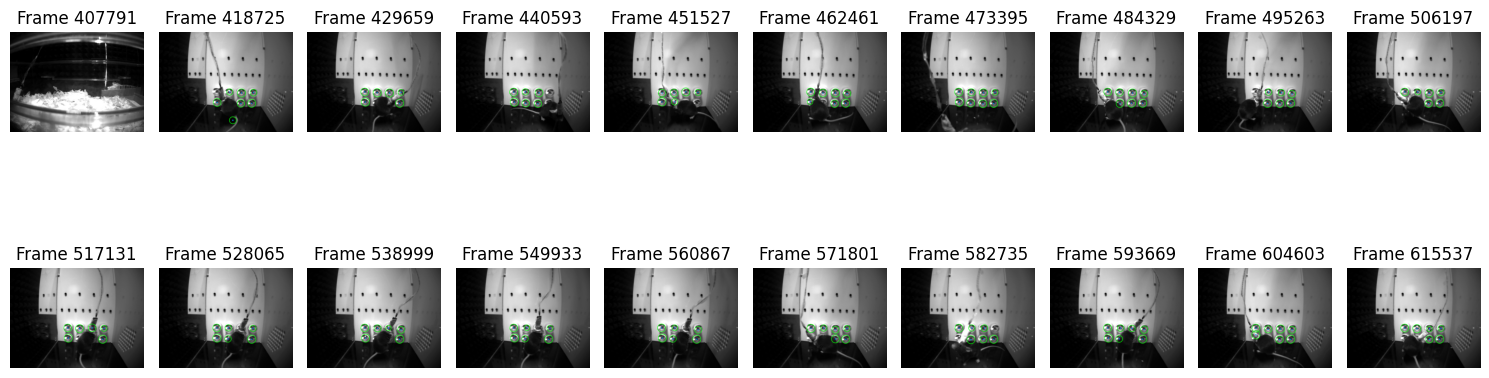

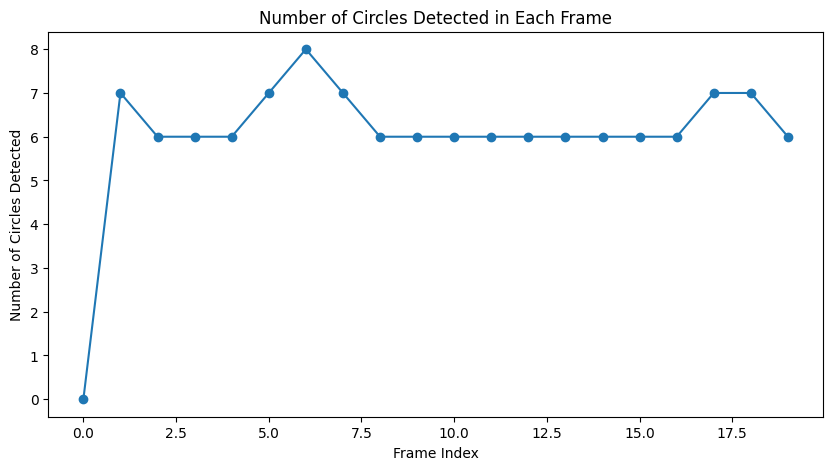

True


In [9]:
import os
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip



ABOVE_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\DLC_video_dump\ABOVE\\"
out_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\DLC_video_dump\ABOVE\trimmed_for_network_training\\"

for file in os.listdir(ABOVE_path):
    if '.avi' in file:
        cam_path = os.path.join(ABOVE_path,file)
        save_path = os.path.join(out_path,file)
        start = 100
        end = 800
        ffmpeg_extract_subclip(cam_path, start, end, save_path)
       

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)


KeyboardInterrupt: 